In [15]:
import os

# Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.stata import StataReader

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.formula.api as sm


# Profiling
import ydata_profiling as yp

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
# from libpysal.weights import Queen
# from libpysal import weights
# from esda import Moran, Moran_Local, G_Local
# from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# 1. Reading the data

In [16]:
# Read the file and the labels
with StataReader('../../dados/microdados-processados/amostra_domicilios_2010_RJ.dta') as reader:
    data_micro = reader.read(convert_categoricals=False)
    col_labels = reader.variable_labels()
    value_labels = reader.value_labels()

# Remove '_lbl' from the keys in value_labels
value_labels = {k.replace('_lbl', ''): v for k, v in value_labels.items()}

# Apply the labels to the data
for col, labels in value_labels.items():
    if col in data_micro:
        data_micro[col] = data_micro[col].map(labels)

# Apply the labels to the columns
data_micro = data_micro.rename(columns=col_labels)

# Convert ÁREA DE PONDERAÇÃO to int64
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype('int64')
# Transform the column to string, remove the 8th character and convert back to int64
# This is done to make the column joinable with CD_GEOCODB from the SHP data
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype(str).apply(lambda x: x[:7] + x[8:]).astype('int64')


filtra apenas os dados da Região Metropolitana do Rio de Janeiro

In [36]:
df_rio = data_micro[data_micro['CÓDIGO DA MESORREGIÃO'] == 'Metropolitana do Rio de Janeiro']
df_rio.info()
df_rio.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252370 entries, 20219 to 361958
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              252370 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               252370 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                252370 non-null  int64  
 3   CONTROLE                                                                          252370 non-null  float64
 4   PESO AMOSTRAL                                                                     252370 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 252370 non-nul

,UNIDADE DA FEDERAÇÃO,CÓDIGO DO MUNICÍPIO,ÁREA DE PONDERAÇÃO,CONTROLE,PESO AMOSTRAL,REGIÃO GEOGRÁFICA,CÓDIGO DA MESORREGIÃO,CÓDIGO DA MICRORREGIÃO,CÓDIGO DA REGIÃO METROPOLITANA,SITUAÇÃO DO DOMICÍLIO,...,MARCA DE IMPUTAÇÃO NA V0218,MARCA DE IMPUTAÇÃO NA V0219,MARCA DE IMPUTAÇÃO NA V0220,MARCA DE IMPUTAÇÃO NA V0221,MARCA DE IMPUTAÇÃO NA V0222,MARCA DE IMPUTAÇÃO NA V0301,MARCA DE IMPUTAÇÃO NA V0401,MARCA DE IMPUTAÇÃO NA V0402,MARCA DE IMPUTAÇÃO NA V0701,Situação do setor
20219,Rio de Janeiro,Belford Roxo,330045605001,6538.0,1.851585e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
20220,Rio de Janeiro,Belford Roxo,330045605001,7249.0,1.531119e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
20221,Rio de Janeiro,Belford Roxo,330045605001,8556.0,2.292746e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
20222,Rio de Janeiro,Belford Roxo,330045605001,8921.0,2.425975e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
20223,Rio de Janeiro,Belford Roxo,330045605001,9069.0,1.810956e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada


# 2. Importando SHP

In [42]:
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')
gdf_rio = gdf[gdf['NM_MUNICIP'].isin(df_rio['CÓDIGO DO MUNICÍPIO'].str.upper().unique())]
gdf_rio.head()

,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry
1095,44839,330045605010040,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41065 -22.75696, -43.41135 -22.7..."
1096,44840,330045605010041,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41013 -22.76033, -43.41040 -22.7..."
1097,44841,330045605010042,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41403 -22.75713, -43.41392 -22.7..."
1098,44842,330045605010043,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41194 -22.75891, -43.41329 -22.7..."
1099,44843,330045605010044,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41182 -22.75986, -43.41285 -22.7..."


In [84]:
# Read the shapefile
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')

# Filter the data to only the city of Rio de Janeiro
gdf_rio = gdf[gdf['NM_MUNICIP'].isin(df_rio['CÓDIGO DO MUNICÍPIO'].str.upper().unique())]

# Select the column with the code of the area and the geometry
selected_columns = ['CD_GEOCODB', 'NM_BAIRRO', 'geometry']
# gdf_rio = gdf_rio[selected_columns]
# gdf_rio['id_loc'] = gdf_rio.apply(lambda row: row['CD_GEOCODM'] if pd.isnull(row.iloc[0]) else row['CD_GEOCODB'], axis=1)
# gdf_rio['id_loc'] = gdf_rio['id_loc'].astype('int64')
gdf_rio['id_loc'] = gdf_rio['CD_GEOCODB']

loc_nulls = gdf_rio[gdf_rio['id_loc'].isnull()]['NM_MUNICIP'].unique()

gdf_rio['id_loc'] = gdf_rio['id_loc'].fillna(gdf_rio['NM_MUNICIP'])

gdf_rio.info()
gdf_rio.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 21153 entries, 1095 to 27876
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          21153 non-null  int64   
 1   CD_GEOCODI  21153 non-null  object  
 2   TIPO        21153 non-null  object  
 3   CD_GEOCODB  18260 non-null  object  
 4   NM_BAIRRO   18260 non-null  object  
 5   CD_GEOCODS  21153 non-null  object  
 6   NM_SUBDIST  12844 non-null  object  
 7   CD_GEOCODD  21153 non-null  object  
 8   NM_DISTRIT  21153 non-null  object  
 9   CD_GEOCODM  21153 non-null  object  
 10  NM_MUNICIP  21153 non-null  object  
 11  NM_MICRO    21153 non-null  object  
 12  NM_MESO     21153 non-null  object  
 13  geometry    21153 non-null  geometry
 14  id_loc      21153 non-null  object  
dtypes: geometry(1), int64(1), object(13)
memory usage: 2.6+ MB


c:\Python39\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,ID,CD_GEOCODI,TIPO,CD_GEOCODB,NM_BAIRRO,CD_GEOCODS,NM_SUBDIST,CD_GEOCODD,NM_DISTRIT,CD_GEOCODM,NM_MUNICIP,NM_MICRO,NM_MESO,geometry,id_loc
1095,44839,330045605010040,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41065 -22.75696, -43.41135 -22.7...",330045605002
1096,44840,330045605010041,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41013 -22.76033, -43.41040 -22.7...",330045605002
1097,44841,330045605010042,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41403 -22.75713, -43.41392 -22.7...",330045605002
1098,44842,330045605010043,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41194 -22.75891, -43.41329 -22.7...",330045605002
1099,44843,330045605010044,URBANO,330045605002,Santo Antônio da Prata,33004560501,AREIA BRANCA,330045605,BELFORD ROXO,3300456,BELFORD ROXO,RIO DE JANEIRO,METROPOLITANA DO RIO DE JANEIRO,"POLYGON ((-43.41182 -22.75986, -43.41285 -22.7...",330045605002


## 3. Transformação dos dados

## 3.2. Agregando os dados por área de ponderação

In [85]:
df_rio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252370 entries, 20219 to 361958
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              252370 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               252370 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                252370 non-null  int64  
 3   CONTROLE                                                                          252370 non-null  float64
 4   PESO AMOSTRAL                                                                     252370 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 252370 non-nul

In [86]:
# Choose a column to be the numeric column
data_columns = ['ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO']
value = ' Não'
aux_columns = ['ÁREA DE PONDERAÇÃO', 'PESO AMOSTRAL', 'CÓDIGO DO MUNICÍPIO'] + data_columns
var = data_columns[0]

# Select only the columns that will be used
df_rio_filtered = df_rio[aux_columns]
df_rio_filtered['id_loc'] = df_rio_filtered.apply(
    lambda row: row['ÁREA DE PONDERAÇÃO'] if row['CÓDIGO DO MUNICÍPIO'].upper() not in loc_nulls else row['CÓDIGO DO MUNICÍPIO'].upper(), 
    axis=1
)

# Group the DataFrame and calculate the weighted average
# df_rio_filtered = df_rio_filtered.fillna(df_rio_filtered.mean())
df_rio_filtered  = df_rio_filtered.fillna(value)


df_rio_filtered[var + '_pct'] = df_rio_filtered[var].apply(lambda x: 1 if x != value else 0)

# Calculate the weighted average
# df_rio_grouped = df_rio_filtered.groupby('ÁREA DE PONDERAÇÃO').apply(lambda x: pd.Series({col: weighted_avg(x, col, 'PESO AMOSTRAL') for col in data_columns}))
df_rio_grouped = df_rio_filtered.groupby('id_loc').mean()

C:\Users\gianl\AppData\Local\Temp\ipykernel_30616\1569498244.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rio_filtered['id_loc'] = df_rio_filtered.apply(
C:\Users\gianl\AppData\Local\Temp\ipykernel_30616\1569498244.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_rio_grouped = df_rio_filtered.groupby('id_loc').mean()


In [87]:
df_rio_grouped.info()
df_rio_grouped.head()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 330045605001 to VASSOURAS
Data columns (total 3 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   ÁREA DE PONDERAÇÃO                      250 non-null    float64
 1   PESO AMOSTRAL                           250 non-null    float64
 2   ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct  250 non-null    float64
dtypes: float64(3)
memory usage: 7.8+ KB


,ÁREA DE PONDERAÇÃO,PESO AMOSTRAL,"ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct"
id_loc,,,
330045605001,3.300456e+11,2.130246e+14,0.994138
330045605002,3.300456e+11,2.080346e+14,0.955364
330045605003,3.300456e+11,2.045050e+14,0.961980
330045605004,3.300456e+11,2.098585e+14,0.855660
330045605005,3.300456e+11,2.054247e+14,0.850685


## 3.2. Juntando os dados com o Shapefile

In [91]:
gdf_rio_filter = gdf_rio[['geometry', 'id_loc']].set_index('id_loc')

# Join the dataframes
gdf_rio_join = gdf_rio_filter.join(df_rio_grouped, how='inner')

gdf_rio_join.info()
gdf_rio_join.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2893 entries, CACHOEIRAS DE MACACU to VASSOURAS
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   geometry                                2893 non-null   geometry
 1   ÁREA DE PONDERAÇÃO                      2893 non-null   float64 
 2   PESO AMOSTRAL                           2893 non-null   float64 
 3   ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct  2893 non-null   float64 
dtypes: float64(3), geometry(1)
memory usage: 177.5+ KB


,geometry,ÁREA DE PONDERAÇÃO,PESO AMOSTRAL,"ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct"
id_loc,,,,
CACHOEIRAS DE MACACU,"POLYGON ((-42.66228 -22.47224, -42.66261 -22.4...",3.300803e+11,1.062114e+14,0.976247
CACHOEIRAS DE MACACU,"POLYGON ((-42.65543 -22.46628, -42.65562 -22.4...",3.300803e+11,1.062114e+14,0.976247
CACHOEIRAS DE MACACU,"POLYGON ((-42.65485 -22.46648, -42.65526 -22.4...",3.300803e+11,1.062114e+14,0.976247
CACHOEIRAS DE MACACU,"POLYGON ((-42.66232 -22.46270, -42.66242 -22.4...",3.300803e+11,1.062114e+14,0.976247
CACHOEIRAS DE MACACU,"POLYGON ((-42.65423 -22.46124, -42.65605 -22.4...",3.300803e+11,1.062114e+14,0.976247


# 3. Plotando o mapa

In [93]:
# Define the bins and labels
var = data_columns[0]
bins = [0, 0.8, 0.9, 0.95, 0.98, 0.99, 1]  # replace with your list of values
labels = ['menor que 80%', 'entre 80% e 90%', 'entre 90% e 95%', 'entre 95% e 98%', 'entre 98% e 99%', 'entre 99% e 100%']

# Create the new column
gdf_rio_join[var + '_cat'] = pd.cut(gdf_rio_join[var + '_pct'], bins=bins, labels=labels, include_lowest=True)

In [94]:
gdf_rio_join

,geometry,ÁREA DE PONDERAÇÃO,PESO AMOSTRAL,"ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_pct","ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO_cat"
id_loc,,,,,
CACHOEIRAS DE MACACU,"POLYGON ((-42.66228 -22.47224, -42.66261 -22.4...",3.300803e+11,1.062114e+14,0.976247,entre 95% e 98%
CACHOEIRAS DE MACACU,"POLYGON ((-42.65543 -22.46628, -42.65562 -22.4...",3.300803e+11,1.062114e+14,0.976247,entre 95% e 98%
CACHOEIRAS DE MACACU,"POLYGON ((-42.65485 -22.46648, -42.65526 -22.4...",3.300803e+11,1.062114e+14,0.976247,entre 95% e 98%
CACHOEIRAS DE MACACU,"POLYGON ((-42.66232 -22.46270, -42.66242 -22.4...",3.300803e+11,1.062114e+14,0.976247,entre 95% e 98%
CACHOEIRAS DE MACACU,"POLYGON ((-42.65423 -22.46124, -42.65605 -22.4...",3.300803e+11,1.062114e+14,0.976247,entre 95% e 98%
...,...,...,...,...,...
VASSOURAS,"POLYGON ((-43.55471 -22.52659, -43.55485 -22.5...",3.306206e+11,1.049578e+14,0.977507,entre 95% e 98%
VASSOURAS,"POLYGON ((-43.58285 -22.28996, -43.58447 -22.2...",3.306206e+11,1.049578e+14,0.977507,entre 95% e 98%
VASSOURAS,"POLYGON ((-43.54603 -22.32615, -43.54644 -22.3...",3.306206e+11,1.049578e+14,0.977507,entre 95% e 98%


In [95]:
var = data_columns[0] + '_cat'

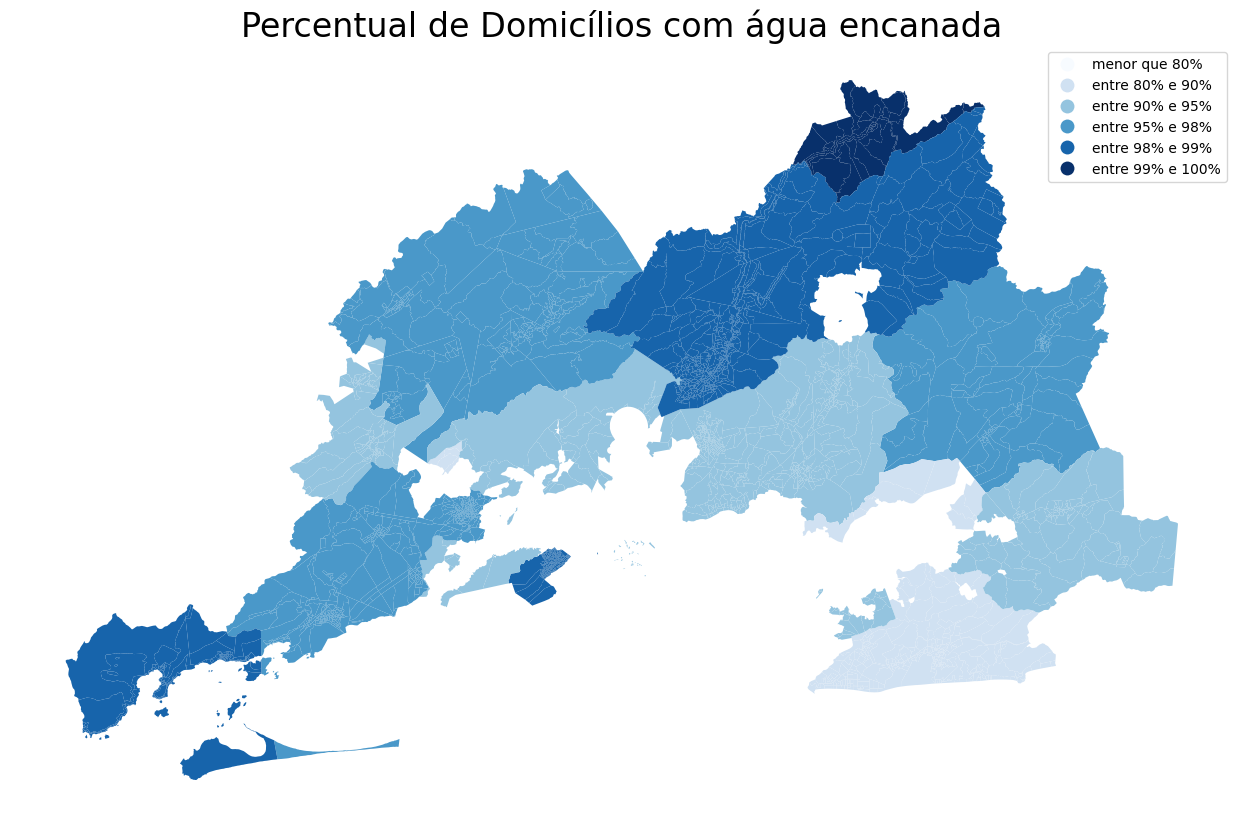

In [96]:
def plot_map(
        gdf, 
        column, 
        title, 
        cmap='viridis', 
        figsize=(16, 10),
        alpha=0.5
    ):
    # Filter the GeoDataFrame to only the column of interest
    gdf = gdf[['geometry', column]]
    
    # Plot the GeoDataFrame
    ax = gdf.plot(
        column=column, 
        figsize=figsize, 
        alpha=alpha, 
        cmap=cmap, 
        # edgecolor='k', 
        legend=True,
        # legend_kwds={'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.01, 'aspect': 50},
        vmin=0    
    )

    ax.set_axis_off()
    
    plt.title(title, fontsize=24)
    plt.show()


plot_map(
    gdf_rio_join, 
    column=var, 
    title='Percentual de Domicílios com água encanada',
    cmap='Blues',
    alpha=1,
    figsize=(16, 10)
    )

In [26]:
# Define the bins and labels
var = data_columns[0]
bins = [0, 0.8, 0.9, 0.95, 0.98, 0.99, 1]  # replace with your list of values
labels = ['menor que 80%', 'entre 80% e 90%', 'entre 90% e 95%', 'entre 95% e 98%', 'entre 98% e 99%', 'entre 99% e 100%']

# Create the new column
df_rio_grouped[var + '_cat'] = pd.cut(df_rio_grouped[var + '_pct'], bins=bins, labels=labels, include_lowest=True)

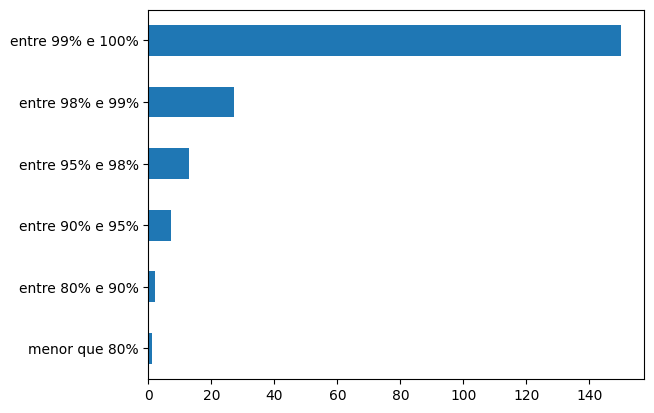

In [27]:
df_rio_grouped[var + '_cat'].value_counts().sort_values(ascending=True).plot.barh();

In [28]:
u = gdf_rio_join.drop(columns=['geometry']).drop_duplicates()
u.sort_values(by=var, ascending=True).head(10)

KeyError: 'ABASTECIMENTO DE ÁGUA, CANALIZAÇÃO'